## Importing Dependencies


In [ ]:
!pip install tensorflow-io[tensorflow]

In [ ]:
!pip install nlpaug

In [ ]:
!pip install cmapy

In [13]:
import os
import cv2
import random
import cmapy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd
import soundfile as sf

#augmentation
import tensorflow_io as tfio
import nlpaug.augmenter.audio as naa

#train_test_split
from sklearn.model_selection import train_test_split

## Load Data

In [5]:
root = '/content/drive/MyDrive/hack/datasets/'

In [7]:
df = pd.read_csv(root + 'processed.csv')
df.head()

,start,end,pid,mode,filename,disease,crack_wheeze
0,1.862,5.718,160,mc,160_1b3_Al_mc_AKGC417L_0.wav,COPD,2
1,5.718,9.725,160,mc,160_1b3_Al_mc_AKGC417L_1.wav,COPD,3
2,9.725,13.614,160,mc,160_1b3_Al_mc_AKGC417L_2.wav,COPD,2
3,13.614,17.671,160,mc,160_1b3_Al_mc_AKGC417L_3.wav,COPD,2
4,17.671,19.541,160,mc,160_1b3_Al_mc_AKGC417L_4.wav,COPD,0


In [9]:
concat_df = pd.read_csv(root + 'final_concat_df.csv', index_col=[0])
concat_df.head()

,start,end,pid,mode,filename,disease,crack_wheeze
0,NaN,NaN,NaN,NaN,aug_crackle_450.wav,NaN,1
1,NaN,NaN,NaN,NaN,aug_crackle_451.wav,NaN,1
2,NaN,NaN,NaN,NaN,aug_crackle_452.wav,NaN,1
3,NaN,NaN,NaN,NaN,aug_crackle_453.wav,NaN,1
4,NaN,NaN,NaN,NaN,aug_crackle_454.wav,NaN,1


In [10]:
sr = 16000
maxLen = 7

In [11]:
smart_pad = np.load(root+'smart_pad.npy')

In [29]:
concat_7sec = np.load(root+'concat_dupli_pad.npy')

In [27]:
concat_7sec_label = []
for idx in range (len(concat_df)):
    label = concat_df['crack_wheeze'][idx]
    concat_7sec_label.append(label)

## Train_Test Split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(smart_pad, df.crack_wheeze,
                                                    stratify=df['crack_wheeze'],
                                                    random_state=42,
                                                    test_size=0.4)

In [15]:
print('train:', len(x_train), len(y_train))
print('test:', len(x_test), len(y_test))

train: 4138 4138
test: 2760 2760


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


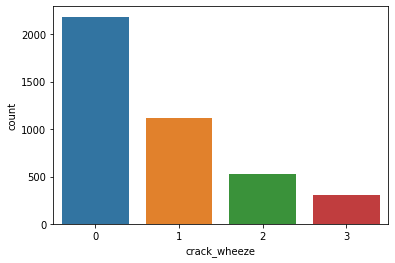

In [16]:
import seaborn as sns
sns.countplot(y_train)

## Augmentation

In [20]:
#slicing
def audio_slicing(signal, max = 7 * sr):
    if len(signal) > max:
        return signal[:max]
    else:
        return signal

#### Shift augmentation

In [17]:
def shift_aug(signal, sr=sr):
    aug = naa.ShiftAug(sampling_rate=sr, duration=random.uniform(1.5, 3.5))
    return aug.augment(signal)

#### Speed augmentation

In [18]:
def speed_aug(signal, sr=sr):
    aug = naa.SpeedAug(zone=(0.2, 0.8), coverage=0.5, factor=(0.5, 1), stateless=True)
    return aug.augment(signal)

#### Applying augmentation

In [19]:
def pre_aug(signal, label, sr=sr):
    prob = np.random.randint(0,2)
    if prob == 0:
        return shift_aug(signal), label
    else:
        aug = speed_aug(signal)
        return audio_slicing(aug), label

In [21]:
train_arr = []
for idx in range(len(x_train)):
    augmented = pre_aug(np.array(x_train)[idx], np.array(y_train)[idx], sr=sr)
    train_arr.append(augmented)

In [22]:
len(train_arr)

4138

In [34]:
for idx in range(len(concat_7sec)):
    augmented = pre_aug(concat_7sec[idx], concat_7sec_label[idx], sr=sr)
    train_arr.append(augmented)

In [35]:
len(train_arr)

10271

In [36]:
np.save(root+'train_arr.npy', train_arr)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Mel feature extraction & Blank region clipping


#### train set
padded x_train, augmented x_train, padded_concat, augmented_concat 

In [37]:
n_mels = 128
f_min = 100
f_max = 16000
nfft = 2048
hop = nfft//4

In [38]:
#mel feature extraction
def create_mel_raw(current_window, sr, n_mels=128, f_min=100, f_max=16000, nfft=2048, hop=512, resz=1):
    S = lb.feature.melspectrogram(y=current_window, sr=sr, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=hop)
    S = lb.power_to_db(S, ref=np.max)
    S = (S-S.min()) / (S.max() - S.min())
    S *= 255
    img = cv2.applyColorMap(S.astype(np.uint8), cmapy.cmap('magma'))
    height, width, _ = img.shape
    if resz > 0:
        img = cv2.resize(img, (width*resz, height*resz), interpolation=cv2.INTER_LINEAR) #bicubic interpolation
    img = cv2.flip(img, 0)
    return img

In [39]:
#blank region clipping
blank_clipped_train = []
for idx in range(len(train_arr)):
    audio_image = cv2.cvtColor(create_mel_raw(np.array(train_arr)[idx][0], sr, n_mels, f_min, f_max, nfft, hop, resz=3), cv2.COLOR_BGR2RGB)
    audio_raw_gray = cv2.cvtColor(create_mel_raw(np.array(train_arr)[idx][0], sr, n_mels, f_min, f_max, nfft, hop), cv2.COLOR_BGR2GRAY)

    audio_raw_gray[audio_raw_gray < 10] = 0
    for row in range(audio_raw_gray.shape[0]):
        black_percent = len(np.where(audio_raw_gray[row,:]==0)[0])/len(audio_raw_gray[row,:])
        if black_percent < 0.80:
            break

    if (row+1)*3 < audio_image.shape[0]:
        audio_image = audio_image[(row+1)*3:, :, :]
    audio_image = cv2.resize(audio_image, (audio_image.shape[1], n_mels*3), interpolation=cv2.INTER_LINEAR)
    audio_image, _, __ = cv2.split(audio_image)
    audio_image = cv2.resize(audio_image, (219, 128), interpolation=cv2.INTER_LINEAR)
    audio_image = np.array(audio_image, dtype=float)

    blank_clipped_train.append(audio_image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [40]:
def processed(signal, label):
    return signal, label

In [41]:
train_list = []
for i in range(len(train_arr)):
    blank_t = processed(blank_clipped_train[i], train_arr[i][1])
    train_list.append(blank_t)

In [42]:
blank_clipped_concat = []
for idx in range(len(concat_7sec)):
    audio_image = cv2.cvtColor(create_mel_raw(np.array(concat_7sec)[idx], sr, n_mels, f_min, f_max, nfft, hop, resz=3), cv2.COLOR_BGR2RGB)
    audio_raw_gray = cv2.cvtColor(create_mel_raw(np.array(concat_7sec)[idx], sr, n_mels, f_min, f_max, nfft, hop), cv2.COLOR_BGR2GRAY)

    audio_raw_gray[audio_raw_gray < 10] = 0
    for row in range(audio_raw_gray.shape[0]):
        black_percent = len(np.where(audio_raw_gray[row,:]==0)[0])/len(audio_raw_gray[row,:])
        if black_percent < 0.80:
            break

    if (row+1)*3 < audio_image.shape[0]:
        audio_image = audio_image[(row+1)*3:, :, :]
    audio_image = cv2.resize(audio_image, (audio_image.shape[1], n_mels*3), interpolation=cv2.INTER_LINEAR)
    audio_image, _, __ = cv2.split(audio_image)
    audio_image = cv2.resize(audio_image, (219, 128), interpolation=cv2.INTER_LINEAR)
    audio_image = np.array(audio_image, dtype=float)

    blank_clipped_concat.append(audio_image)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [43]:
for i in range(len(concat_7sec)):
    blank_c = processed(blank_clipped_concat[i], concat_7sec_label[i])
    train_list.append(blank_c)

In [44]:
blank_clipped_x_train = []
for idx in range(len(x_train)):
    audio_image = cv2.cvtColor(create_mel_raw(np.array(x_train)[idx], sr, n_mels, f_min, f_max, nfft, hop, resz=3), cv2.COLOR_BGR2RGB)
    audio_raw_gray = cv2.cvtColor(create_mel_raw(np.array(x_train)[idx], sr, n_mels, f_min, f_max, nfft, hop), cv2.COLOR_BGR2GRAY)

    audio_raw_gray[audio_raw_gray < 10] = 0
    for row in range(audio_raw_gray.shape[0]):
        black_percent = len(np.where(audio_raw_gray[row,:]==0)[0])/len(audio_raw_gray[row,:])
        if black_percent < 0.80:
            break

    if (row+1)*3 < audio_image.shape[0]:
        audio_image = audio_image[(row+1)*3:, :, :]
    audio_image = cv2.resize(audio_image, (audio_image.shape[1], n_mels*3), interpolation=cv2.INTER_LINEAR)
    audio_image, _, __ = cv2.split(audio_image)
    audio_image = cv2.resize(audio_image, (219, 128), interpolation=cv2.INTER_LINEAR)
    audio_image = np.array(audio_image, dtype=float)

    blank_clipped_x_train.append(audio_image)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [45]:
for i in range(len(x_train)):
    blank_x = processed(blank_clipped_x_train[i], np.array(y_train)[i])
    train_list.append(blank_x)

In [46]:
np.save(root+'train_list.npy', train_list)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [54]:
new_x_train = []
new_y_train = []
for i in range(len(train_list)):
    new_x_train.append(train_list[i][0])
    new_y_train.append(train_list[i][1])

In [48]:
print(len(new_x_train))
print(len(new_y_train))

20542
20542


In [49]:
from collections import Counter

Counter(y_train)

Counter({0: 2185, 1: 1118, 2: 531, 3: 304})

In [55]:
Counter(new_y_train)

Counter({0: 4370, 1: 5078, 2: 5470, 3: 5624})

In [50]:
np.save(root+'x_train.npy', new_x_train)
np.save(root+'y_train.npy', new_y_train)

#### test set

In [51]:
blank_clipped_x_test = []
for idx in range(len(x_test)):
    audio_image = cv2.cvtColor(create_mel_raw(np.array(x_test)[idx], sr, n_mels, f_min, f_max, nfft, hop, resz=3), cv2.COLOR_BGR2RGB)
    audio_raw_gray = cv2.cvtColor(create_mel_raw(np.array(x_test)[idx], sr, n_mels, f_min, f_max, nfft, hop), cv2.COLOR_BGR2GRAY)

    audio_raw_gray[audio_raw_gray < 10] = 0
    for row in range(audio_raw_gray.shape[0]):
        black_percent = len(np.where(audio_raw_gray[row,:]==0)[0])/len(audio_raw_gray[row,:])
        if black_percent < 0.80:
            break

    if (row+1)*3 < audio_image.shape[0]:
        audio_image = audio_image[(row+1)*3:, :, :]
    audio_image = cv2.resize(audio_image, (audio_image.shape[1], n_mels*3), interpolation=cv2.INTER_LINEAR)
    audio_image, _, __ = cv2.split(audio_image)
    audio_image = cv2.resize(audio_image, (219, 128), interpolation=cv2.INTER_LINEAR)
    audio_image = np.array(audio_image, dtype=float)

    blank_clipped_x_test.append(audio_image)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [52]:
print(len(blank_clipped_x_test))
print(len(y_test))

2760
2760


In [56]:
Counter(y_test)

Counter({0: 1457, 1: 746, 2: 355, 3: 202})

In [53]:
np.save(root+'x_test.npy', blank_clipped_x_test)
np.save(root+'y_test.npy', y_test)